# Import packages and set seeds

In [5]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from scipy.interpolate import griddata
from matplotlib import cm

import numpy as np
import time
#from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
import pandas as pd
import copy

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 

cuda


In [2]:
!pwd

/scratch/s.1915438/outputs/HIVE_baseline_PINN


In [3]:
!bash -c 'echo $CUDA_VISIBLE_DEVICES'

MIG-1e6f2bd9-1626-5f95-a2ab-da54aa4ce3ca


In [4]:
print(f"Device name: {torch.cuda.get_device_name(0)}")
!nvidia-smi -i 0

Device name: NVIDIA A100-PCIE-40GB MIG 2g.10gb
Thu Mar 21 15:25:58 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  Off  | 00000000:27:00.0 Off |                   On |
| N/A   36C    P0    33W / 250W |     48MiB / 40960MiB |     N/A      Default |
|                               |                      |              Enabled |
+-------------------------------+----------------------+----------------------+

+---------------------------------------

# Data Preparation
Training and Testing data is prepared from the solution file

In [8]:
# Load the CSV files into DataFrames
df_ground_truth = pd.read_csv('data/ground_truth.csv')
df_pipeface_temp = pd.read_csv('data/PipeFace_Temperature.csv')
df_tiletop_temp = pd.read_csv('data/TileTop_Temperature.csv')

In [9]:
# Convert the DataFrames to NumPy arrays
nodes = df_ground_truth.iloc[:, 0:3].to_numpy()
nodal_coordinates_pipeface = df_pipeface_temp.iloc[:, 0:3].to_numpy()
nodal_coordinates_tiletop = df_tiletop_temp.iloc[:, 0:3].to_numpy()

In [14]:
# Vertically stack the nodal coordinates from both files
#boundary_nodal_coordinates = np.vstack((nodal_coordinates_pipeface, nodal_coordinates_tiletop))

# Extract the fourth column (the solution) from each DataFrame
temperature = df_ground_truth.iloc[:, 3].to_numpy().reshape(-1, 1)
solution_pipeface = df_pipeface_temp.iloc[:, 3].to_numpy().reshape(-1, 1)
solution_tiletop = df_tiletop_temp.iloc[:, 3].to_numpy().reshape(-1, 1)

# Vertically stack the solutions from both files
#boundary_solution = np.vstack((solution_pipeface.reshape(-1, 1), solution_tiletop.reshape(-1, 1)))

In [16]:
np.shape(nodes), np.shape(nodal_coordinates_pipeface), np.shape(nodal_coordinates_tiletop)

((29133, 3), (749, 3), (3108, 3))

In [17]:
 np.shape(temperature), np.shape(solution_pipeface), np.shape(solution_tiletop)

((29133, 1), (749, 1), (3108, 1))

In [68]:
min = temperature.min()
max = temperature.max()

In [19]:
solution_pipeface.min(), solution_pipeface.max()

(32.9914, 37.1586)

In [21]:
solution_tiletop.min(), solution_tiletop.max()

(41.4127, 55.8483)

In [27]:
# Bounds shall be in accordance with nodes[x,y,z]
ub = nodes.max(axis=0)
lb = nodes.min(axis=0)

print('Variables :    x  y   z')
print('Lower bound : ', lb)
print('Upper bound : ', ub)

Variables :    x  y   z
Lower bound :  [-1.0842e-19  0.0000e+00  0.0000e+00]
Upper bound :  [0.03  0.05  0.025]


# Physics-informed neural network 

In [43]:
class Sequentialmodel(nn.Module):
    def __init__(self, layers):
        super().__init__() 
        #call __init__ from parent class to initialise the torch.nn.Module
              
        # Activation function
        self.activation = nn.Tanh()
        
        # Loss function
        # A help on why we are using mean reduction 
        # https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        # Initialise neural network as a list using nn.Modulelist 
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        self.iter = 0 # Initialise iteration variable        
        
        # Xavier Normal Initialization
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            # https://discuss.pytorch.org/t/calculate-gain-tanh/20854/4
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.1)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
    def forward(self,x):
        # Forward pass
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        # preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()

        
        for i in range(len(layers)-2): # last layer is not activated
            
            z = self.linears[i](a)
                        
            a = self.activation(z)
            
        a = self.linears[-1](a) # linear feedforward no activation in the output layer (y= mx+c)
        
        return a
        
    def loss_BC(self,x,y):
        # Boundary condition loss 
        # Splitting the forward pass and loss computation to visualise the pointwise loss
        #forwarded_BC = self.forward(x)
        loss_u = self.loss_function(self.forward(x),y)
                
        return loss_u

    def loss_PDE(self, x_to_train_f):
        # 3D heat conduction with constant k and no heat generation term
        # We don't need k in steady state and without heat source
        # T_xx + T_yy + T_zz = 0
        # This is also known as the Laplace equation
        
        x_1_f = x_to_train_f[:,[0]]
        x_2_f = x_to_train_f[:,[1]]
                        
        g = x_to_train_f.clone() # x_to_train_f is tensor without requires_grad and let us not distrub it.
                        
        g.requires_grad = True
        
        u = self.forward(g)

        # First derivative of u w.r.t to all inputs i.e. x, y and z
        u_x_y_z = autograd.grad(u,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        # Second derivative of u w.r.t to all inputs i.e. x, y and z                        
        u_xx_yy_zz = autograd.grad(u_x_y_z,g,torch.ones(x_to_train_f.shape).to(device), create_graph=True)[0]
        # Since there are 3 input vectors x,y and z                                                    

        u_xx = u_xx_yy_zz[:,[0]]
        u_yy = u_xx_yy_zz[:,[1]]
        u_zz = u_xx_yy_zz[:,[2]]
                                                                   
        f = u_xx + u_yy + u_zz # PDE remians the same
        
        loss_f = self.loss_function(f,f_hat) # f_hat is global variable in the main section
                
        return loss_f    
    
    def test(self):
        # we don't have true solution (u) to play with            
        u_pred = self.forward(X_collocation)
        error_vec = torch.linalg.norm((u_test-u_pred),2)/torch.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
        u_pred = u_pred.cpu().detach().numpy()                
        
        return error_vec, u_pred 
       

# Main

In [83]:
# Convert numpy arrays to tensors 
X_collocation = torch.from_numpy(nodes).float().to(device)
X_pipeface_coord = torch.from_numpy(nodal_coordinates_pipeface).float().to(device)
X_tiletop_coord = torch.from_numpy(nodal_coordinates_tiletop).float().to(device)

u_pipeface = torch.from_numpy(solution_pipeface).float().to(device)
u_tiletop = torch.from_numpy(solution_tiletop).float().to(device)
u_test = torch.from_numpy(temperature).float().to(device)

f_hat = torch.zeros(nodes.shape[0],1).to(device) # PDE residual label

layers = [3] + [60]*8 + [1] # Units in hidden layers
#layers = np.array([3,50,50,50,50,1]) 
#layers = np.array([3,100,100,100,100,1]) 

PINN = Sequentialmodel(layers)
bestPINN = Sequentialmodel(layers) # this is our model with lowest training because PINNs don't have validation but testing error
# We do not need to assign this to a device as we will not train the bestPINN model.
PINN.to(device) # last iteration PINN
bestPINN.to(device) # best PINN on the basis of the training loss

params = list(PINN.parameters()) # params of the NN

# Adam optimiser
optimizer = optim.Adam(PINN.parameters(), lr=0.001,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4000, gamma=0.95) # LR scheduler


max_iter = 10000

pipeface_loss_array = np.zeros(max_iter)
tiletop_loss_array = np.zeros(max_iter)
PDE_loss_array = np.zeros(max_iter)
total_loss_array = np.zeros(max_iter)
#test_error_array = np.zeros(max_iter)
#flag = np.zeros(max_iter,dtype=bool)

start_time = time.time()
for i in range(max_iter):
    pipeface_loss =  PINN.loss_BC(X_pipeface_coord, u_pipeface) # pipeface loss
    tiletop_loss =  PINN.loss_BC(X_tiletop_coord, u_tiletop) # tiletop loss
    PDE_loss = PINN.loss_PDE(X_collocation) # PDE loss

    total_loss = pipeface_loss + tiletop_loss + PDE_loss
           
    optimizer.zero_grad() # zeroes the gradient in each epoch
    total_loss.backward() # backprop the total loss and store in .grad()
    optimizer.step()  # update parameters
    #scheduler.step() # reduce the lr
    
    #error_vec, _ = PINN.test() # save time by not predicting the u_pred in each iteration
    pipeface_loss_array[i] = pipeface_loss
    tiletop_loss_array[i] = tiletop_loss
    PDE_loss_array[i] = PDE_loss
    total_loss_array[i] = total_loss  
    #test_error_array[i] = error_vec
    
    # printing losses
    if i % (max_iter/100) == 0:
        print(f" Epoch: {i+1} \t Pipe Loss: {pipeface_loss:0.4f}\t Tile Loss: {tiletop_loss:0.4f}\t PDE Loss: {PDE_loss:0.4f} \t Loss: {total_loss:0.4f}")#" \t Test Error: {error_vec:0.4f}")
    if total_loss < 1e-4:
        print(f'Loss converged in {i} Epochs')
        break
        
    # Choosing the best model using the total loss not validation loss
    
    #if i>=2 and test_error_array[i] < np.amin(test_error_array[0:(i-1)]): # if current total loss is the minimum in the test loss array for all previous iterations i.e. [0,i-1]
    if i>=2 and total_loss_array[i] < np.amin(total_loss_array[0:(i-1)]):
        # for i<2, in test_error_array[0:(i-1)] is i-1 is negative (i=0) and null (i=1), so better avoid first two iteration for selecting the best model
        #flag[i] = True
        #print(f'Best model found at {i} th iteration with training loss = {total_loss_array[i]:0.4f}')
        bestPINN.load_state_dict(copy.deepcopy(PINN.state_dict())) # then the current PINN model is the best model, copying the state dictionary to the bestPINN
        # https://discuss.pytorch.org/t/copy-deepcopy-vs-clone/55022
        best_iter = i # save the best iteration to put it on the test error plot
    #else:
    #    flag[i]=False
#     if i % (max_iter/10) == 0:
#         error_vec, _ = PINN.test()
#         print(loss,error_vec)

else:
    print('Training finished')
    elapsed = time.time() - start_time                
    print('Training time(s): %.2f' % (elapsed))
    print(f"Final loss: {total_loss}")
    error_vec, _ = PINN.test()
    print(f"Test loss: {error_vec.item()}")

 Epoch: 1 	 Pipe Loss: 1179.1888	 Tile Loss: 2471.7805	 PDE Loss: 465848.7188 	 Loss: 469499.6875
 Epoch: 101 	 Pipe Loss: 1197.6934	 Tile Loss: 2471.0667	 PDE Loss: 269.5008 	 Loss: 3938.2607
 Epoch: 201 	 Pipe Loss: 1191.1300	 Tile Loss: 2461.1658	 PDE Loss: 103.0502 	 Loss: 3755.3462
 Epoch: 301 	 Pipe Loss: 1183.8657	 Tile Loss: 2450.6050	 PDE Loss: 55.9308 	 Loss: 3690.4016
 Epoch: 401 	 Pipe Loss: 1176.3645	 Tile Loss: 2439.7234	 PDE Loss: 35.7397 	 Loss: 3651.8276
 Epoch: 501 	 Pipe Loss: 1168.7095	 Tile Loss: 2428.6135	 PDE Loss: 26.0716 	 Loss: 3623.3945
 Epoch: 601 	 Pipe Loss: 1160.9325	 Tile Loss: 2417.3242	 PDE Loss: 20.5825 	 Loss: 3598.8394
 Epoch: 701 	 Pipe Loss: 1153.0569	 Tile Loss: 2405.8872	 PDE Loss: 16.9368 	 Loss: 3575.8809
 Epoch: 801 	 Pipe Loss: 1145.0983	 Tile Loss: 2394.3218	 PDE Loss: 14.2440 	 Loss: 3553.6638
 Epoch: 901 	 Pipe Loss: 1137.0657	 Tile Loss: 2382.6375	 PDE Loss: 12.1261 	 Loss: 3531.8293
 Epoch: 1001 	 Pipe Loss: 1128.9645	 Tile Loss: 2370.8

In [84]:

#''' Model Accuracy ''' 
#best_error_vec, best_u_pred = bestPINN.test() # use the best model to evaluate the test error
#final_error_vec, final_u_pred = PINN.test()
#print('Best Test Error: %.5f'  % (best_error_vec))
#print('Final Test Error: %.5f'  % (final_error_vec))

_, best_u_pred = bestPINN.test()
_, final_u_pred = PINN.test()

In [85]:
print(PINN.state_dict().keys())
print(PINN.state_dict()['linears.4.weight'])
print(bestPINN.state_dict()['linears.4.weight'])

odict_keys(['linears.0.weight', 'linears.0.bias', 'linears.1.weight', 'linears.1.bias', 'linears.2.weight', 'linears.2.bias', 'linears.3.weight', 'linears.3.bias', 'linears.4.weight', 'linears.4.bias', 'linears.5.weight', 'linears.5.bias', 'linears.6.weight', 'linears.6.bias', 'linears.7.weight', 'linears.7.bias', 'linears.8.weight', 'linears.8.bias'])
tensor([[ 0.0288,  0.0077, -0.0122,  ...,  0.1814, -0.2328, -0.0910],
        [ 0.1548,  0.2950, -0.2383,  ...,  0.0561,  0.1444,  0.0931],
        [ 0.2607, -0.1875, -0.0011,  ...,  0.1980,  0.0274,  0.0436],
        ...,
        [-0.1511, -0.0622, -0.0985,  ...,  0.3536, -0.1495,  0.1519],
        [ 0.0997, -0.0098,  0.0674,  ..., -0.3635,  0.2769, -0.0327],
        [ 0.0294,  0.1456, -0.2040,  ..., -0.2494, -0.0091,  0.0011]],
       device='cuda:0')
tensor([[ 0.0288,  0.0077, -0.0122,  ...,  0.1814, -0.2328, -0.0910],
        [ 0.1548,  0.2950, -0.2383,  ...,  0.0561,  0.1444,  0.0931],
        [ 0.2607, -0.1875, -0.0011,  ...,  0.19

In [ ]:
#solutionplot(u_pred,X_u_train.cpu().detach().numpy(),u_train.cpu().detach().numpy())

In [23]:
#best_error_vec = best_error_vec.cpu().detach().numpy() # detach from GPU to CPU
#final_error_vec = final_error_vec.cpu().detach().numpy() # detach from GPU to CPU

# Save arrays in npy file

In [86]:
## Saving list
# Input nodes: nodes
# ground truth: temperature
# max_iter = max_iter
# best iteration number: best_iter
# best model: best_error_vec, best_u_pred 
# final model: final_error_vec, final_u_pred
# Loss arrays: total_loss_array, BC_loss_array, PDE_loss_array, test_error_array

np.savez('results/Results_Data_'+str(max_iter)+'_iteration.npz', 
         nodes = nodes, 
         temperature = temperature,
         max_iter = max_iter,
         #best_error_vec = best_error_vec,
         best_u_pred = best_u_pred,
         #final_error_vec = final_error_vec,
         final_u_pred = final_u_pred,
         best_iter = best_iter,
         PDE_loss_array = PDE_loss_array,
         pipeface_loss_array = pipeface_loss_array,
         tiletop_loss_array = tiletop_loss_array,
         total_loss_array = total_loss_array)
         #test_error_array = test_error_array)

In [26]:
# Plot test error (no test error)
#plt.figure(1,figsize=(8, 8), dpi=80)
# plt.figure(1,dpi=300)
# iter_array = np.arange(0,max_iter)
# plt.plot(iter_array,test_error_array)
# plt.plot([best_iter,best_iter],[0,best_error_vec],'o-k')
# plt.xlabel('Epoch')
# plt.ylabel('Test Error')
# plt.legend(['Best error: ' +str(best_error_vec),'best iteration: '+str(best_iter)])
# plt.ylim(bottom=0)  # https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.ylim.html
#plt.savefig('Test_error_'+str(max_iter)+'_iteration.jpg',dpi=150)

In [ ]:
# Detach loss tensors
#print(np.shape(total_loss_array))
#print(total_loss_array)
#print(BC_loss_array)
#print(PDE_loss_array)
#print(np.array_equal(PDE_loss_array,BC_loss_array))

Text(0, 0.5, 'Loss')

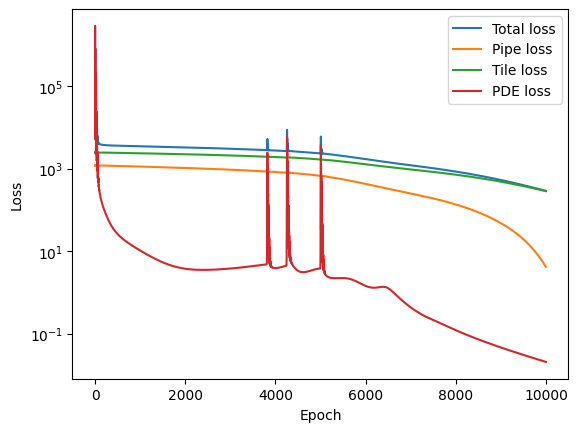

In [87]:
plt.figure(2, dpi=100)

iter_array = np.arange(0,max_iter)
plt.plot(iter_array, total_loss_array, label = "Total loss")
plt.plot(iter_array, pipeface_loss_array, label = "Pipe loss")
plt.plot(iter_array, tiletop_loss_array, label = "Tile loss")
plt.plot(iter_array, PDE_loss_array, label = "PDE loss")
plt.legend()
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.savefig('loss_'+str(max_iter)+'_iteration.jpg',dpi=150)

In [40]:
# np.unique(nodes[:,2])

Text(0.5, 0, 'z')

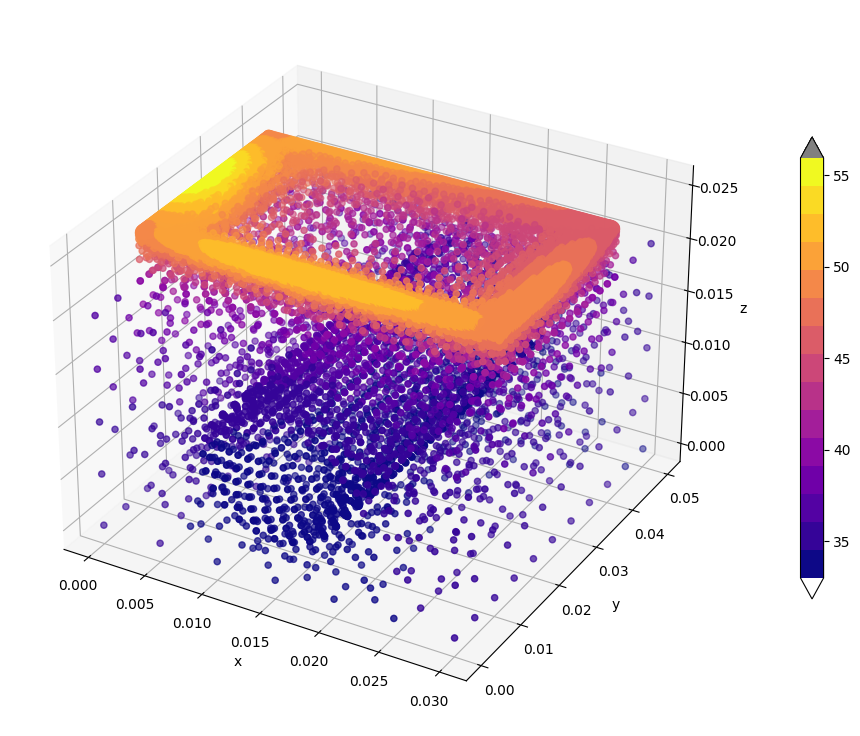

In [88]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(nodes[:,0], nodes[:,1], nodes[:,2], c = temperature, cmap=plt.get_cmap('plasma', 15), vmin=min, vmax=max)
sc.cmap.set_under('white')
sc.cmap.set_over('gray')
plt.colorbar(sc, shrink=0.5,pad=0.08,extend='both')

plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')

In [91]:
# fig = plt.figure(figsize=(12,12))
# ax = fig.add_subplot(111, projection='3d')
# sc = ax.scatter(nodal_coordinates_pipeface[:,0], nodal_coordinates_pipeface[:,1], nodal_coordinates_pipeface[:,2], c = solution_pipeface, cmap=plt.get_cmap('plasma', 15), vmin=min, vmax=max)
# sc1 = ax.scatter(nodal_coordinates_tiletop[:,0], nodal_coordinates_tiletop[:,1], nodal_coordinates_tiletop[:,2], c = solution_tiletop, cmap=plt.get_cmap('plasma', 15), vmin=min, vmax=max)

# sc.cmap.set_under('white')
# sc.cmap.set_over('gray')
# plt.colorbar(sc, shrink=0.5,pad=0.08,extend='both')

# plt.xlabel('x')
# plt.ylabel('y')
# ax.set_zlabel('z')

Text(0.5, 0, 'z')

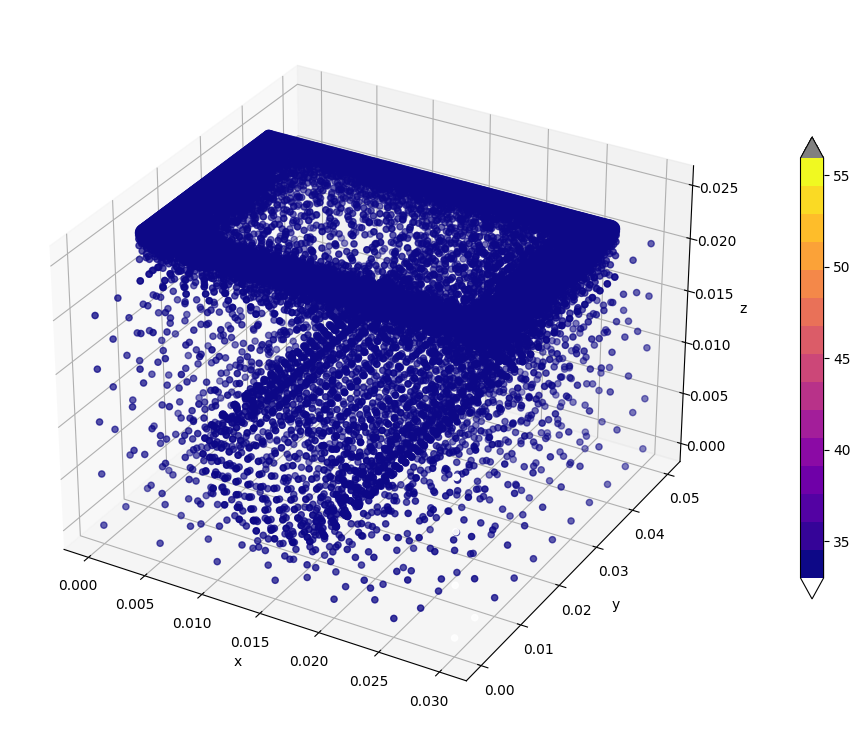

In [92]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(nodes[:,0], nodes[:,1], nodes[:,2], c = best_u_pred, cmap=plt.get_cmap('plasma', 15), vmin=min, vmax=max)
sc.cmap.set_under('white')
sc.cmap.set_over('gray')
plt.colorbar(sc, shrink=0.5,pad=0.08,extend='both')

plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')

Text(0.5, 0, 'z')

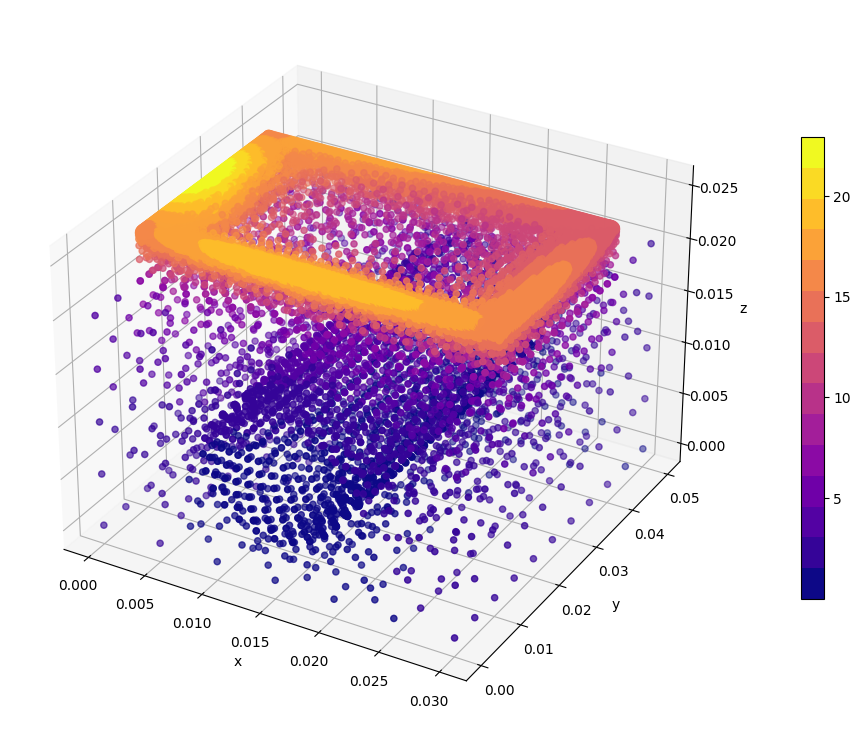

In [96]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(nodes[:,0], nodes[:,1], nodes[:,2], c = abs(best_u_pred - temperature), cmap=plt.get_cmap('plasma', 15))#, vmin=min, vmax=max)
#sc.cmap.set_under('white')
#sc.cmap.set_over('gray')
plt.colorbar(sc, shrink=0.5,pad=0.08)#,extend='both')

plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')